# 04. PyTorch Custom Datasets

We'll use `torchvision.datasets` to build custom datasets. 

#### The contents

Topic	Contents
0. Importing PyTorch and setting up device-agnostic code.
1. Get data	We're going to be using our own custom dataset of pizza, steak and sushi images.
2. Become one with the data (data preparation)	
3. Transforming data - here we'll look at some steps we can take to transform our images so they're ready to be used with a model.
4. Loading data with ImageFolder (option 1)	 ImageFolder is helpful if our images are in standard image classification format.
5. Loading image data with a custom Dataset	What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of torch.utils.data.Dataset.
6. Other forms of transforms (data augmentation) 
7. Model 0: TinyVGG without data augmentation
8. Exploring loss curves
9. Model 1: TinyVGG with data augmentation
10. Compare model results	
11. Making a prediction on a custom image trained model predict on an image outside of our existing dataset.

In [1]:
import torch
from torch import nn 
import matplotlib.pyplot as plt 
import seaborn as sns 

print(f"version {torch.__version__}")

device = "cuda" if torch.cuda.is_available() else "cpu"
device

version 2.1.2+cu118


'cuda'

### 1. Get data

Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

PyTorch has a small version of that for learning pourposes with the 
- `torchvision.datasets.Food101`


In [2]:
import requests
import zipfile 
from pathlib import Path 

# setup path to root folder 
data_path = Path("D:\\Coding_Stuff\\")
image_path = data_path / "FoodVision"

# if image folder doses not exist, download it and prepare... 
if image_path.is_dir():
    print(f"{image_path} directory exists")
else:
    print(f"Did not find {image_path} directory, creating one.....")
    image_path.mkdir(parents=True, exist_ok=True)

    # download the data
    with open(data_path / "FoodVision.zip" , "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza_steak_sushi.........")
        f.write(request.content)

    # unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "FoodVision.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data.......")
        zip_ref.extractall(image_path)

D:\Coding_Stuff\FoodVision directory exists


### 2.Become one with data ( data prep)

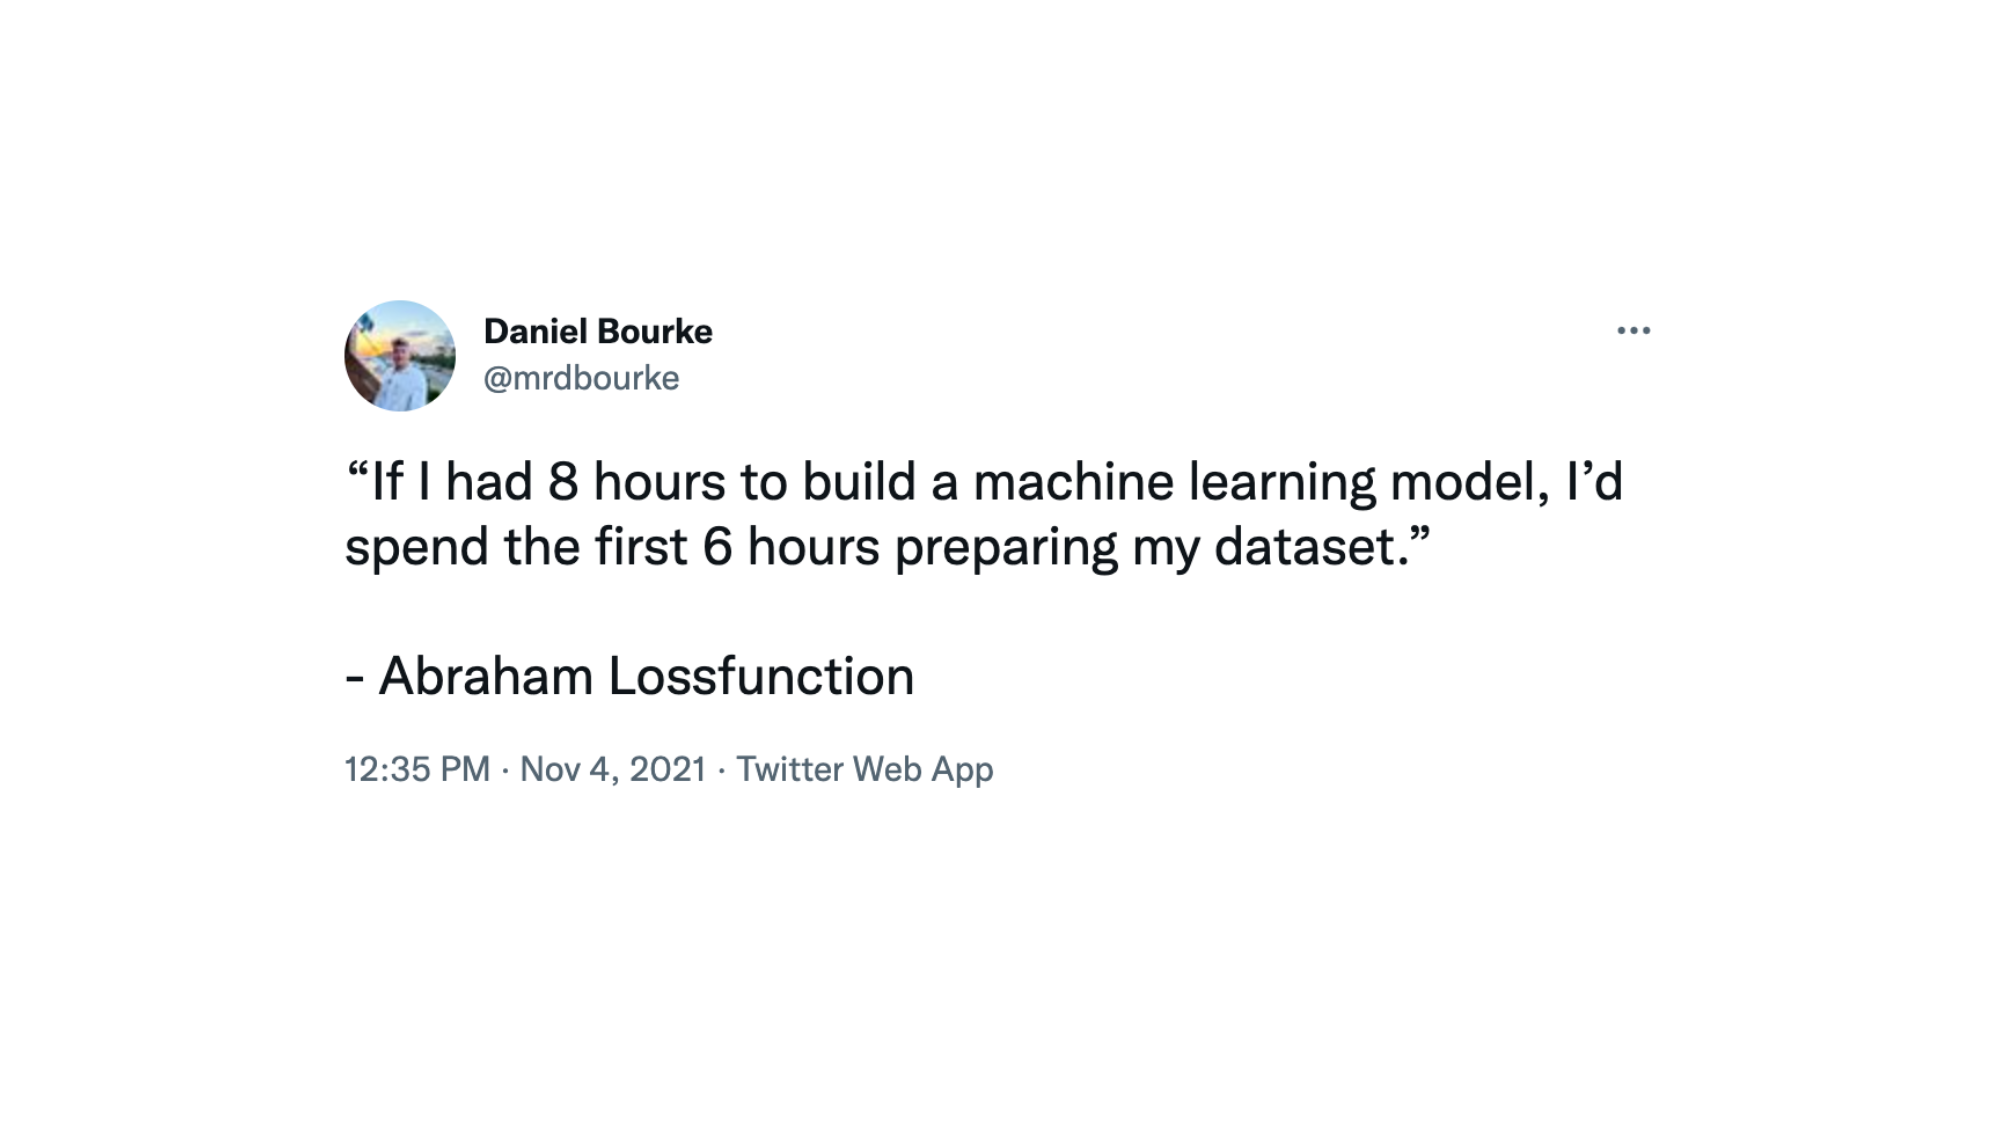

In [3]:
# We'll use os.walk()
import os 
def walk_through_dir(dir_path):

    """
    Walks through dir_path returning its content.
    Args: 
    dir_path (str or path;ib.Path); target dairectory.
    Returns:
    A printout of number of subdairectory,images and each name.
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir("D:\\Coding_Stuff\\FoodVision")

There are 2 directories and 0 images in 'D:\Coding_Stuff\FoodVision'.
There are 3 directories and 0 images in 'D:\Coding_Stuff\FoodVision\test'.
There are 0 directories and 25 images in 'D:\Coding_Stuff\FoodVision\test\pizza'.
There are 0 directories and 19 images in 'D:\Coding_Stuff\FoodVision\test\steak'.
There are 0 directories and 31 images in 'D:\Coding_Stuff\FoodVision\test\sushi'.
There are 3 directories and 0 images in 'D:\Coding_Stuff\FoodVision\train'.
There are 0 directories and 78 images in 'D:\Coding_Stuff\FoodVision\train\pizza'.
There are 0 directories and 75 images in 'D:\Coding_Stuff\FoodVision\train\steak'.
There are 0 directories and 72 images in 'D:\Coding_Stuff\FoodVision\train\sushi'.


In [4]:
# setting image path
train_dir = image_path / "train"
test_dir = image_path / "test" 

train_dir,test_dir

(WindowsPath('D:/Coding_Stuff/FoodVision/train'),
 WindowsPath('D:/Coding_Stuff/FoodVision/test'))

### 1.2 Visualize an image.

1. Get all of image path using `pathlib.Path.glob()` to find all path ending with `.jpg`
2. Pick a random image path using Python's `random.choice()`.
3. get image path usnig `pathlib.Path.parent.stem`
4. open the random image using `PIL.Image.open()`
5. print some metadata.

Random image path: D:\Coding_Stuff\FoodVision\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


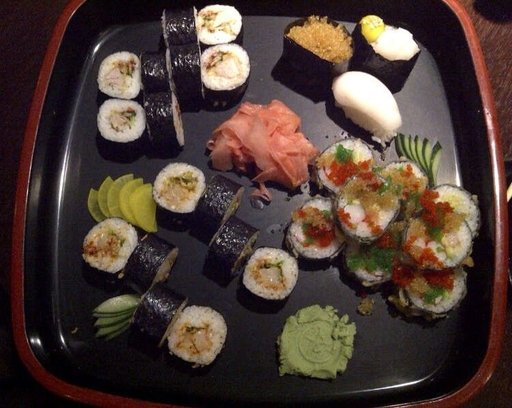

In [5]:
from PIL import Image
from pathlib import Path
import random 

# set seed 
random.seed(42)

# Get image path 
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Get random image
random_image_path = random.choice(image_path_list)

# Get image class from path 
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

### 3.Transforming Data 

Using `torch.utils.data.Dataset` we turn images into Pytorch Dataset and later subsequently into `torch.utils.data.DataLoader`.

There are several kinds of datasets, for each data.

Problem space	Pre-built Datasets and Functions
- Vision	torchvision.datasets
- Audio	torchaudio.datasets
- Text	torchtext.datasets
- Recommendation system	torchrec.datasets

we'll use `torchvision.dataset` for dataloading we'll use `torchvision.transform`.

In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms,datasets

`torchvision.transforms` have pre-built functions to format images, turning them into tensors and manipulating them for **data augmentation** . 
- `transforms.Rezise()`
- `transforms.randomHorizondalFlip()`
- `trnasforms.ToTensor()`

we compile all this using `torchvision.transforms.Compose()`.

In [7]:
# write transforms for image
data_transform = transforms.Compose([
    # Reszie image
    transforms.Resize(size=(64,64)),
    # Flip the image randomly
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn image into torch.tensor
    transforms.ToTensor()
])

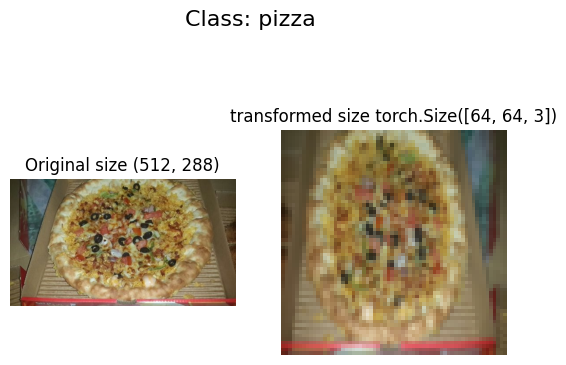

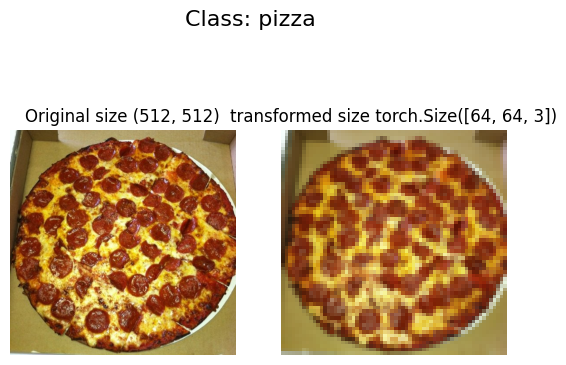

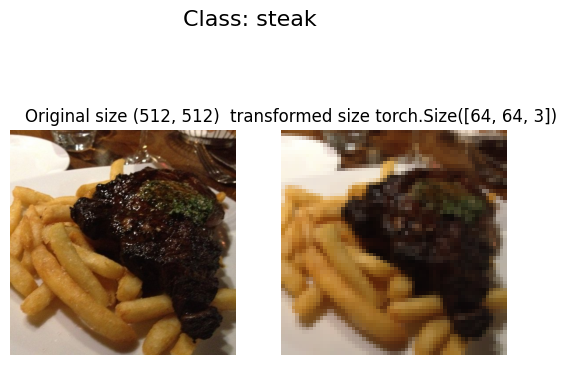

In [8]:
def plot_transformed_images(image_paths: list, transform , n=3, seed = None):
    """
    Plot a series of random image from image_paths by taking 
    a random image.

    Args:
        image_paths (list): List of image paths
        transform (PyTorch transform): data transformation pipeline 
        n (int): number of samples
        seed (int, optional)
    """

    random.seed(seed)
    random_image_paths = random.sample(image_path_list, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original size {f.size}")
            ax[0].axis("off")

            # transform applied Note: permute() will not change shape of image , it shift axis
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"transformed size {transformed_image.size()}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

### 4. Option 1: Loading Image Data Using `ImageFolder`

Since our data is standard image classification format, we can use the `torchvision.datasets.ImageFolder`. 


In [9]:
# Use ImageFolder to create dataset(s).

from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                transform=data_transform,
                                target_transform=None)

print(f"Train Data \n {train_data}  Test Data \n {test_dir}")

Train Data 
 Dataset ImageFolder
    Number of datapoints: 225
    Root location: D:\Coding_Stuff\FoodVision\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )  Test Data 
 D:\Coding_Stuff\FoodVision\test


In [17]:
print(f"Class names :{train_data.classes}")
print(f"converting class names to dict ; {train_data.class_to_idx}")
print(f"Len of class : {len(train_data)}")

# sample image and label from traindata
img,label = train_data[0][0], train_data[0][1]
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Class names :['pizza', 'steak', 'sushi']
converting class names to dict ; {'pizza': 0, 'steak': 1, 'sushi': 2}
Len of class : 225
Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


In [19]:
img.shape

torch.Size([3, 64, 64])

Text(0.5, 1.0, 'pizza')

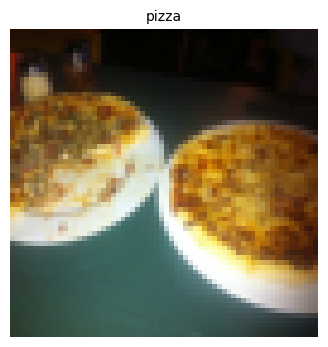

In [16]:
# Rearrange the order of dimensions
img = img.permute(1,2,0)

#plotting the image 
plt.figure(figsize=(7,4))
plt.imshow(img)
plt.axis("off")
plt.title(train_data.classes[label], fontsize = 10)

#### 4.1 loading data using DataLoader 

we'll do so using `torch.utils.data.DataLoader`, to keep things simple we'll 

Use `batch_size = 1` and `num_worker=1`(It defines how many subprocesses will be created to load your data).

In [21]:
print(f"Number of CPUs {os.cpu_count()}")

# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=2, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=2, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

Number of CPUs 8


(<torch.utils.data.dataloader.DataLoader at 0x124770eec50>,
 <torch.utils.data.dataloader.DataLoader at 0x124770efa30>)

In [22]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


### 5. Option 2: Loading Image data with Custom `Dataset`

- pros and cons of own custom way to load `Dataset`

Pros of creating a custom Dataset	
1. Can create a Dataset out of almost anything.	
2. Not limited to PyTorch pre-built Dataset functions.

Cons of creating a custom Dataset

1. Even though you could create a Dataset out of almost anything, it doesn't mean it will work.
2. Using a custom Dataset often results in writing more code, which could be prone to errors or performance issues.

Replicating the `torchvision.datasets.ImageFolder()` by subclassing `torch.utils.data.Dataset.`

In [40]:
import os 
from pathlib import Path
import torch 
import glob 

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import List,Tuple, Dict

In [28]:
# Image folder had function to get class_names and also indexes 
train_data.classes , train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 5.1 Creating Helper functions to get class names. 

In [33]:
target_directory = train_dir
print(f"Target directory{train_dir}")

class_names = sorted([entity.name for entity in list(os.scandir(target_directory))])
print(f"Class names {class_names}")

Target directoryD:\Coding_Stuff\FoodVision\train
Class names ['pizza', 'steak', 'sushi']


In [86]:
# let's put it into function 
# byuilding a function to get class names in target directory

def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
    """
    Find the class folder names in the given directory

    Args: 
        directory (str) : target directory of images to load from 
    Returns:
        Tuple[List(str), Dict(str,int)]: (list of class names), (class name: index)

    Assumes the folder is in standard Image classification format. 
    """
    # 1. Get class name s
    classes = sorted(entity.name for entity in list(os.scandir(directory)) if entity.is_dir())

    #2. Rise error if path does not exist. 
    if not classes:
        raise FileNotFoundError(f"The {directory} does not exist")
    
    # 3. Create a dictionary of labels, index 
    class_to_idx = {index:class_name for class_name, index in enumerate(classes)}
    
    return classes , class_to_idx

find_classes(directory=train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 5.2 Creating custom `Dataset` to replicate `ImageFolder`.

Breaking it down. 

1. Subclass `torch.utils.data.Dataset` class.
2. Initialize our subclass with `tag_dir` (target directory) and `transfom`.
3. Create a function to load images files and return them, this can be `PIL` or `torchvision.io`.
4. Overwrite `__len__` method of `torch.utils.data.Dataset` , this is recommended but not required.
5. Overwrite the `__getitem__` method too. This is required.  

In [90]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass dataset 
class ImageFolderCustom(Dataset):
    
    #2. Initialize tag_dir, transforms etc 
    def __init__(self, tar_dir: str, transform = None) -> None:
        
        # create all class attributes to get images, setup transforms 
        self.paths = list(pathlib.Path(tar_dir).glob("*/*.jpg"))
        self.transform = transform
        # get class_names and class_to_idx 
        self.class_names, self.class_to_idx = find_classes(tar_dir)

    #3. Make function t load images 
    def load_image(self, index:int) -> Image.Image:
        "Opens an image via path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    #4. Overwrite __len__() function. 
    def __len__(self) -> int:
        "Retruns total number of samples"        
        return len(self.paths)
    
    #5. Overwrite __genitem__() function.
    def __getitem__(self, index:int) -> Tuple[torch.tensor, int]:
        "Returns one sample of data and coresponding label"
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects in std img classification format.
        class_idx = self.class_to_idx[class_name]

        # transform if nessesary 
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [91]:
train_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()])

test_transfoms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()]
)

In [92]:
### Momment of truth!!! ####

train_data_custom = ImageFolderCustom(tar_dir=train_dir,
                                      transform=train_transform)
test_data_custom = ImageFolderCustom(tar_dir=test_dir,
                                     transform=test_transfoms)


#### Testing functions ####
print(train_data_custom.class_names, train_data_custom.class_to_idx)

img, label = train_data_custom[0]
print(img[:1], label)

['pizza', 'steak', 'sushi'] {'pizza': 0, 'steak': 1, 'sushi': 2}
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]]]) 0
